![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('workingday').total.describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


La varibale ''workingday'' indica si el día del registro del alquiler de las biciletas era un día hábil o no. La variable es 0 si el día no era hábil y 1 si lo era. 

Podemos observar que hay 3470 registros en días no hábiles y 74120 en días hábiles. También es posible afirmar que en promedio hubo 189 alquileres en días no hábiles y 193 alquileres en día hábiles. 

Además, podemos ver que el máximo número de rentas en días no hábiles fue 738 y que el mínimo fue de 1, mientras que en días hábiles el máximo fue 977 y el mínimo 1 también. 

Es posible inferir que se alquilaron más bicicletas en días hábiles que en días no hábiles. 

Por último, podemos observar que en días no hábiles el 75% de alquileres fue de 304 o menos, mientras que en días hábiles este 75% fue 277 o menos. 

In [5]:
# Celda 1.2
bikes.groupby('hour').total.describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


La variable ''hour'' representa la hora del día de los alquileres. la variable toma el valor de 0 para las 00:00:00 horas y 23 para las 23:00:00 horas. 

De esta variable podemos observar que la media del alquiler más alta se dio a las 17:00:00 horas, es decir a las 5 de la tarde. También es posible ver que apoximadamente a las 8 horas y a las 17 hay más alquileres. Probablemente porque son las horas donde las personas salen y vuelven a sus hogares. 

Por último, observamos también que a las 5 de la tarde, el 75% de alquileres corresponde a aproximadamente 608 o menos, siendo este el valor más alto del percentil 75 de todas las horas del día. 


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

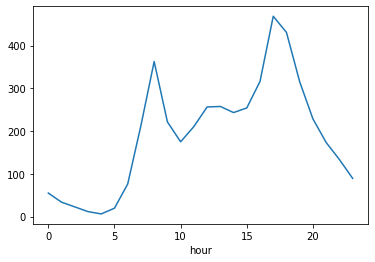

In [6]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

En esta gráfica, podemos ver las rentas promedio para cada valor de la variable "hour" que es practicamente una representación de la media de la información descriptiva que habíamos encontrado en el punto anterior. 

Podemos observar que la media del alquiler más alta se dio a las 17:00:00 horas, y que apoximadamente a las 8 horas y a las 17 hay más promedio de alquileres. Probablemente porque son las horas donde las personas salen y vuelven a sus hogares.

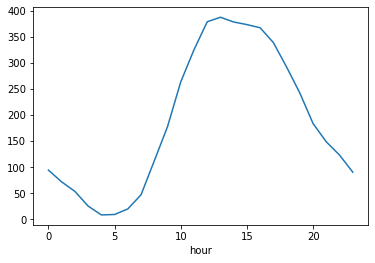

In [7]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos
bikes_0=bikes[bikes['workingday']==0]
bikes_0.groupby('hour').total.mean().plot()

En esta gráfica podemos ver las rentas promedio para cada valor de la variable "hour" cuando la variable ''workingday'' es igual a 0, es decir cuando no es un día hábil. 

Podemos observar que el mayor promedio de alquileres en estos días se dio en horas de la tarde, aproximadamente desde las 12 hasta las 17 horas. 

El menor promedio de alquileres se encontró aproximadamente a las 4 y luego de las 5 empezó a incrementarse. A eso de las 17 horas el promedio de alquileres vuelve a disminiur a medida que van pasando las horas. 

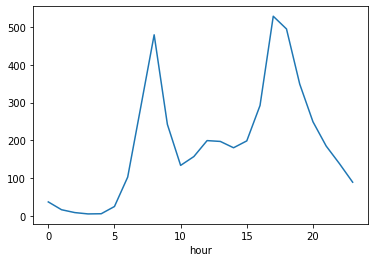

In [8]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes_1=bikes[bikes['workingday']==1]
bikes_1.groupby('hour').total.mean().plot()

En esta gráfica podemos ver las rentas promedio para cada valor de la variable "hour" cuando la variable ''workingday'' es igual a 1, es decir cuando es un día hábil.

Podemos observar que el mayor promedio de alquileres en estos días se dio en alrededor de las 8 y las 17 horas, muy parecido a la distribución que observamos de la gráfia de rentas promedio para cada valor de la variable "hour" para todos los días. Esto puede deberse a que hay más datos para este tipo de días. 

El menor promedio de alquileres se encontró aproximadamente a las 4 y luego de las 5 empezó a incrementarse hasta alrededor de las 8 donde volvió a bajar hasta las 10. Ahí, se mantuvo con pequeñas variaciones hasta las 15, donde empezó a subir y alcanzó su punto máximo alrededor de las 17 horas, para luego ir bajando a medida que pasaban las horas. 

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [9]:
# Celda 3
X = bikes.loc[:,['workingday','hour']].reset_index(drop=True)
y = bikes['total'].reset_index(drop=True)

#Regresion lineal
reg = LinearRegression().fit(X, y)
print('Score: ', reg.score(X, y))
print('Coeficientes: ', reg.coef_)
print('Intercepto: ', reg.intercept_)

Score:  0.16059115011434866
Coeficientes:  [ 4.07248627 10.49206282]
Intercepto:  67.70595026191623


Text(0, 0.5, 'Total')

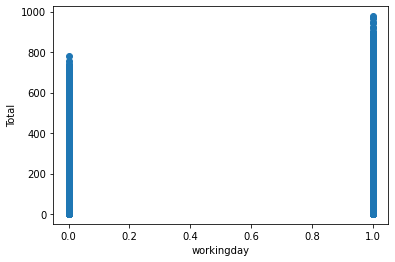

In [10]:
plt.scatter(X['workingday'], y)
plt.xlabel("workingday")
plt.ylabel("Total")

Text(0, 0.5, 'Total')

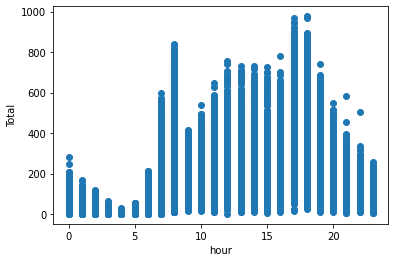

In [11]:
plt.scatter(X['hour'], y)
plt.xlabel("hour")
plt.ylabel("Total")

Podemos ver que los coeficientes de la regresión líneal son 4.07 y 10.49 en este caso. Por tando, podemos decir que hay una correlación positiva entre cada predictor y la variable dependiente. 

Sin embargo, es posible también observar que el score o el coeficiente de determinación de la predicción obtenido es bastante bajo. Por lo que podemos concluir que un modelo de regresión líneal no se adapta muy bien a este caso pues no se ajusta a los datos. 

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [12]:
# Celda 4
# Definición de la función que calcula residuals 
def residuals(y):
  return y-np.mean(y)

# Definición de la función mse_impurity para calular la ganancia de una variable predictora j dado el punto de corte k
def mse_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    res_l = residuals(y_l)
    res_r = residuals(y_r)

    res=np.concatenate((res_l, res_r), axis=None)
    n = len(res)
    r = res ** 2
    r = np.sum(r)
    
    mse_impurity_ =  r / n
    
    return mse_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte para hacer la bifurcación del árbol
def best_split(X, y, num_pct):
  features = range(X.shape[1])
    
  best_split = [0, 0, 0]  # j, split, gain
  gainarr=[]
    
  # Para todas las varibles 
  for j in features:
        
      splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
      splits = np.unique(splits)
      
  
      # Para cada partición
      for split in splits:
          gain = mse_impurity(X.iloc[:, j], y, split)
          gainarr.append(gain)
          
          if gain == min(gainarr):
            best_split = [j, split, gain]
  

  return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0) 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

tree = tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)
tree

{'gain': 23675.892974467795,
 'level': 0,
 'n_samples': 10886,
 'sl': {'gain': 4569.219380357905,
  'level': 1,
  'n_samples': 3594,
  'sl': {'gain': 1242.1585299291187,
   'level': 2,
   'n_samples': 3139,
   'sl': {'gain': 754.3758482230121,
    'level': 3,
    'n_samples': 2684,
    'split': -1,
    'y_pred': 1,
    'y_prob': 25.15934475055845},
   'split': [1, 6.0],
   'sr': {'gain': 1509.6453517339166,
    'level': 3,
    'n_samples': 455,
    'split': -1,
    'y_pred': 1,
    'y_prob': 75.92778993435448},
   'y_pred': 1,
   'y_prob': 32.561604584527224},
  'split': [1, 7.0],
  'sr': {'gain': 12425.746772115539,
   'level': 2,
   'n_samples': 455,
   'sl': {'gain': 1891.2862782401903,
    'level': 3,
    'n_samples': 145,
    'split': -1,
    'y_pred': 1,
    'y_prob': 46.63265306122449},
   'split': [0, 1.0],
   'sr': {'gain': 17353.15571279917,
    'level': 3,
    'n_samples': 310,
    'split': -1,
    'y_pred': 1,
    'y_prob': 288.83012820512823},
   'y_pred': 1,
   'y_prob': 

Construimos el árbol de regresión usando el valor MSE como parámetro para definir el best_split o la mejor división. Elegimos el nodo con el menor MSE para definir el nodo de origen y continuar dividiendo el árbol hasta obtener 6 nodos finales.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [13]:
# Celda 5
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

df = pd.DataFrame({'Real Values':y_test, 'Predicted Values':y_pred})
print('Precisión del modelo:')
print(regressor.score(X_train, y_train))
df

Precisión del modelo:
0.6512896280920657


,Real Values,Predicted Values
3709,308,321.701923
6741,14,8.624000
9848,539,320.070707
1410,143,199.282158
10672,1,8.048889
...,...,...
5096,50,133.737288
7007,384,283.934783
6813,24,24.609756
301,14,37.333333


In [14]:
for i in range(1, 11):
  regressor_var = DecisionTreeRegressor(max_depth=i)
  regressor_var.fit(X_train, y_train)
  print(i, regressor_var.score(X_train, y_train))

1 0.3143824180699768
2 0.38767590936201846
3 0.44176135001583094
4 0.47753375716219626
5 0.5861626430506067
6 0.6455551265677908
7 0.6506536740794227
8 0.6511228413436014
9 0.6512865807246182
10 0.6512896280920657


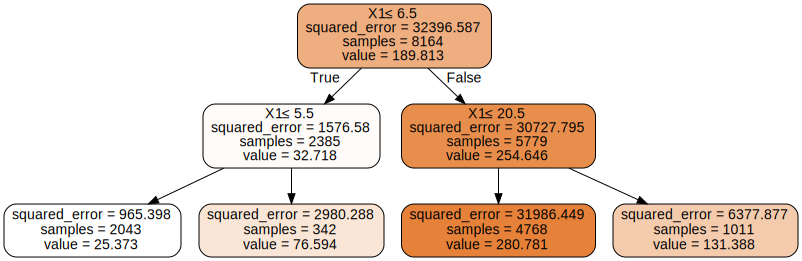

In [15]:
import graphviz
from sklearn import tree
model = DecisionTreeRegressor(max_depth=2)
model.fit(X_train, y_train)

dot_data = tree.export_graphviz(model, 
                  feature_names=None,  
                  class_names=None,  
                  filled=True, rounded=True,  
                  special_characters=True,
                   out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph

Podemos observar que el score o la precisión del modelo obtenida con el árbol de decisión es mayor que la que obtuvimos con la regresión lineal en el punto 3. 

También podemos ver que según la profunidad del árbol tenemos un valor diferente de score. A menor profundidad menor score. De igual manera, en todos los casos sigue siendo mayor al obtenido con regresión lineal por lo que podemos decir que este modelo se ajusta mejor a los datos de las variables ''hour'' y ''workingday'' respecto a la variable ''Total'' que representa la cantidad de alquileres. 

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [16]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [17]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [18]:
# División de la muestra en set de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

#### Árbol de decisión

(0.6308888888888888, 2)

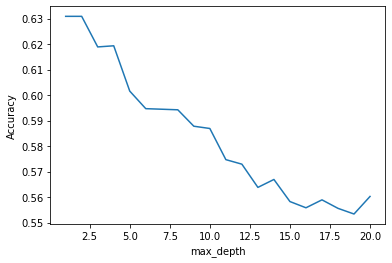

In [19]:
# Celda 6

#Árbol de decisión

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())

# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

In [20]:
# max_depth=2 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=2, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = accuracy_score(y_test, y_pred)
f1=f1_score(y_test, y_pred, average='macro')
print('El accuracy para el árbol de decisión es: ', score)
print('El F1 para el árbil de decisión es: ', f1)

El accuracy para el árbol de decisión es:  0.6453333333333333
El F1 para el árbil de decisión es:  0.6453327028136938


#### Regresión Logística

In [21]:
clf_lr = LogisticRegression().fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
score_lr = accuracy_score(y_test, y_pred_lr)
f1_lr=f1_score(y_test, y_pred_lr, average='macro')
print('El accuracy para regresión logística es: ', score_lr)
print('El F1 para para regresión logísitca es: ', f1_lr)

El accuracy para regresión logística es:  0.614
El F1 para para regresión logísitca es:  0.6139710049332594


Podemos observar que tanto el accuracy como el F1 de los dos modelos son muy parecidos. Las métricas de Árbol de decisión son solo un poco mayores. 

### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

#### 100 árboles de decisión donde max_depth = None con 300 muestras bagged

In [22]:
# Creación de 300 muestras de bootstrap
n_estimators = 100
np.random.seed(123)
n_samples = X_train.shape[0]
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(300)]
# Entrenamiento de 100 modelos con las 300 muestras boostrap
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=len(samples))

trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
f1_none_man=metrics.f1_score(y_pred, y_test)
acc_none_man=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_none_man)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_none_man)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6618892508143323
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.654


#### 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn

In [23]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_none_sk=metrics.f1_score(y_pred, y_test)
acc_none_sk=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn: ', f1_none_sk)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn: ', acc_none_sk)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn:  0.6567567567567568
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn:  0.6613333333333333


#### 100 árboles de decisión donde max_depth = 2 con 300 muestras bagged 

In [24]:
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
f1_dos_man=metrics.f1_score(y_pred, y_test)
acc_dos_man=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_dos_man)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_dos_man)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6573333333333333
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6573333333333333


#### 100 árboles de decisión donde max_depth = 2 con 300 muestras bagged usando sklearn

In [25]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_dos_sk=metrics.f1_score(y_pred, y_test)
acc_dos_sk=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_dos_sk)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_dos_sk)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.631578947368421
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6453333333333333


#### 100 reregiones logísticas con 300 muestras bagged

In [26]:
trees = {}
for i in range(n_estimators):
    trees[i] = LogisticRegression(random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])

# Predicción para los datos del set de test con cada modelo
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = trees[i].predict(X_test)

y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
f1_log_man=metrics.f1_score(y_pred, y_test)
acc_log_man=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_log_man)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_log_man)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6138211382113822
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.62


#### 100 reregiones logísticas con 300 muestras bagged usando sklearn

In [27]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_log_sk=metrics.f1_score(y_pred, y_test)
acc_log_sk=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_log_sk)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_log_sk)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6125760649087221
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.618


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

#### 100 árboles de decisión donde max_depth = None con 300 muestras bagged

In [28]:
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=None, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
f1_none_man_vp=metrics.f1_score(y_pred, y_test)
acc_none_man_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_none_man_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_none_man_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6132971506105835
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.62


#### 100 árboles de decisión donde max_depth = None con 300 muestras bagged usando sklearn

In [29]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=None), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
f1_none_sk_vp=metrics.f1_score(y_pred, y_test)
acc_none_sk_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_none_sk_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_none_sk_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6132971506105835
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.62


#### 100 árboles de decisión donde max_depth = 2 con 300 muestras bagged

In [30]:
trees = {}
for i in range(n_estimators):
    trees[i] = DecisionTreeClassifier(max_features="sqrt", max_depth=2, random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
# Desempeño al hacer votación ponderada
f1_dos_man_vp=metrics.f1_score(y_pred, y_test)
acc_dos_man_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_dos_man_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_dos_man_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6132971506105835
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.62


#### 100 árboles de decisión donde max_depth = 2 con 300 muestras bagged usando sklearn

In [31]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Desempeño al hacer votación ponderada
f1_dos_sk_vp=metrics.f1_score(y_pred, y_test)
acc_dos_sk_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_dos_sk_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_dos_sk_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6324549237170597
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6466666666666666


#### 100 reregiones logísticas con 300 muestras bagged

In [32]:
trees = {}
for i in range(n_estimators):
    trees[i] = LogisticRegression(random_state=seeds[i])
    trees[i].fit(X_train.iloc[samples[i]], y_train.iloc[samples[i]])
samples_oob = []
# Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
for sample in samples:
    samples_oob.append(sorted(set(range(n_samples)) - set(sample)))
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = trees[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - metrics.accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
# Desempeño al hacer votación ponderada
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)
f1_log_man_vp=metrics.f1_score(y_pred, y_test)
acc_log_man_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_log_man_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_log_man_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6142372881355933
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6206666666666667


#### 100 reregiones logísticas con 300 muestras bagged usando sklearn

In [33]:
# Definición del modelo BaggingClassifier de la libreria sklearn
clf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True, max_samples=300)

# Predicción y desempeño al hacer votación mayoritaria
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf.n_estimators))

for i in range(clf.n_estimators):
    oob_sample = ~clf.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)
# Desempeño al hacer votación ponderada
f1_log_sk_vp=metrics.f1_score(y_pred, y_test)
acc_log_sk_vp=metrics.accuracy_score(y_pred, y_test)
print('F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', f1_log_sk_vp)
print('Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged: ', acc_log_sk_vp)

F1 para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.6181818181818182
Accuracy para 100 árboles de decisión donde max_depth = None con 300 muestras bagged:  0.622


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Comparación por F1 manual


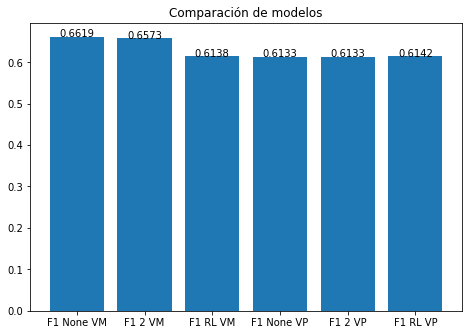

In [34]:
##Comparacion de F1 manualmente 
print('Comparación por F1 manual')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['F1 None VM', 'F1 2 VM', 'F1 RL VM', 'F1 None VP', 'F1 2 VP', 'F1 RL VP']
ejeY = [round(f1_none_man, 4), round(f1_dos_man, 4), round(f1_log_man, 4), round(f1_none_man_vp, 4), round(f1_dos_man_vp, 4), round(f1_log_man_vp, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.show()

Comparación por F1 usando sklearn


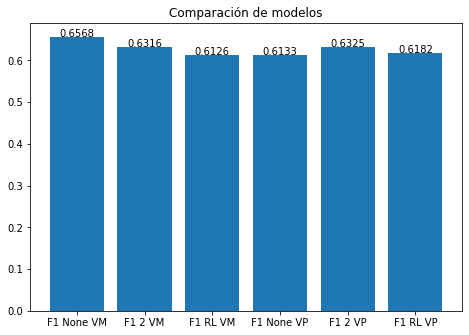

In [35]:
##Comparacion de F1 sklearn 
print('Comparación por F1 usando sklearn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['F1 None VM', 'F1 2 VM', 'F1 RL VM', 'F1 None VP', 'F1 2 VP', 'F1 RL VP']
ejeY = [round(f1_none_sk, 4), round(f1_dos_sk, 4), round(f1_log_sk, 4), round(f1_none_sk_vp, 4), round(f1_dos_sk_vp, 4), round(f1_log_sk_vp, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.show()

Comparación por accuracy manual


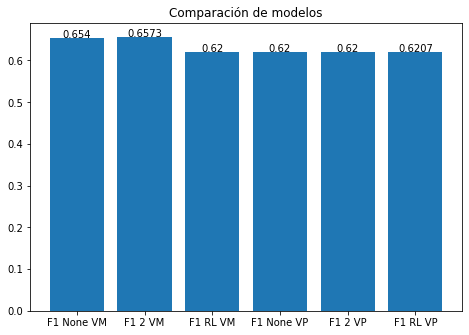

In [36]:
##Comparacion de accuracy manualmente 
print('Comparación por accuracy manual')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['F1 None VM', 'F1 2 VM', 'F1 RL VM', 'F1 None VP', 'F1 2 VP', 'F1 RL VP']
ejeY = [round(acc_none_man, 4), round(acc_dos_man, 4), round(acc_log_man, 4), round(acc_none_man_vp, 4), round(acc_dos_man_vp, 4), round(acc_log_man_vp, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.show()

Comparación por accuracy usando sklearn


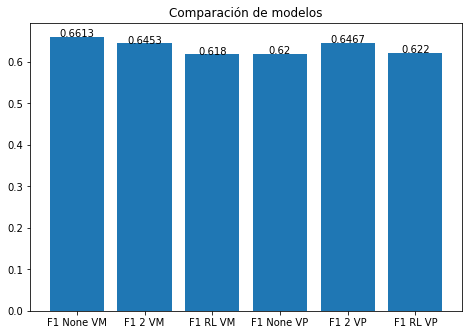

In [37]:
##Comparacion de accuracy sklearn 
print('Comparación por accuracy usando sklearn')
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['F1 None VM', 'F1 2 VM', 'F1 RL VM', 'F1 None VP', 'F1 2 VP', 'F1 RL VP']
ejeY = [round(acc_none_sk, 4), round(acc_dos_sk, 4), round(acc_log_sk, 4), round(acc_none_sk_vp, 4), round(acc_dos_sk_vp, 4), round(acc_log_sk_vp, 4)]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.show()

Podemos observar con 4 gráficas de comparación de modelos los resultados de F1 y accuracy obtenidos para cada una de las pruebas que realizamos construyendo los algoritmos de forma manual y también usando la librería sklearn para 300 muestras bagged y 100 estimadores para cada modelo.

Podemos observar que para el F1 tanto los modelos construidos de forma manual tanto los que usan sklearn concuerdan en que el mayor valor para esta métrica es usar un árbol de decisión con el parámetro max_depth igual a None del modelo por votación mayoritaria. Lo que significa que los nodos del árbol se expandirán hasta que todas las hojas sean puras o hasta que todas las hojas contengan menos muestras que el número mínimo de muestras necesarias para dividir un nodo interno y que el modelo tendrá en cuenta la clase final con la mayor cantidad de votos. Podemos ver también que todos los valores de los modelos para F1 dieron alrededor de 0.6

En cuanto al accuracy, sklearn nos dice que el modelo con el mayor valor es el mismo que obtuvo el mayor valor para F1. Sin embargo, los modelos construidos de forma manual nos indican que es mejor usar un árbol de decisión con parámetro max_depth igual a 2 con votación mayoritaria, aunque la diferencia es muy pequeña.

Podemos concluir entonces que el modelo que mejor se ajusta a los datos teniendo en cuenta los diferentes valores de F1 y accuracy obtenidos, es el de un árbol de decisión con parámetro max_depth igual a None que usa votación mayoritaria.

